# Libraries

In [69]:
!pip install ipynb
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score, silhouette_score
from sklearn.model_selection import StratifiedKFold
import statistics
from sklearn.cluster import KMeans
from ipynb.fs.full.my_functions import *

# Loading the DataSet

https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

In [70]:
gender = pd.read_csv("heart.csv")
balanced_dataset= gender.copy()
balanced_dataset.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Inspecting the Data

In [71]:
H=(balanced_dataset['output'].value_counts()[1])/(len(balanced_dataset))*100
print('percentage of more chance of heart attacks: ',H)
N=balanced_dataset['output'].value_counts()[0]/(len(balanced_dataset))*100
print('percentage of less chance of heart attacks: ',N)

percentage of more chance of heart attacks:  54.45544554455446
percentage of less chance of heart attacks:  45.54455445544555


Initially the dataset is almost balanced with a negligible ratio of imbalance.

<AxesSubplot:xlabel='output', ylabel='count'>

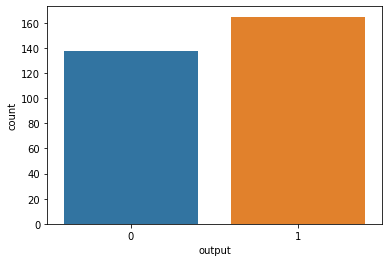

In [72]:
sns.countplot(x="output", data=balanced_dataset)

In [73]:
balanced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Appeantly,there are no categorical features,all the columns contains numerical values.

In [74]:
balanced_dataset.shape

(303, 14)

DataSet has 14 columns and 303 rows.



In [75]:
print('Null Values in the dataset: ',balanced_dataset.isnull().sum().sum())

Null Values in the dataset:  0


No column contains the null values.

In [76]:
print('Duplicates in the dataset: ', balanced_dataset.duplicated().sum())

Duplicates in the dataset:  1


There is only one duplicate row in the dataset so we have to drop it in the pre-processing step.

# Visualizing the Data

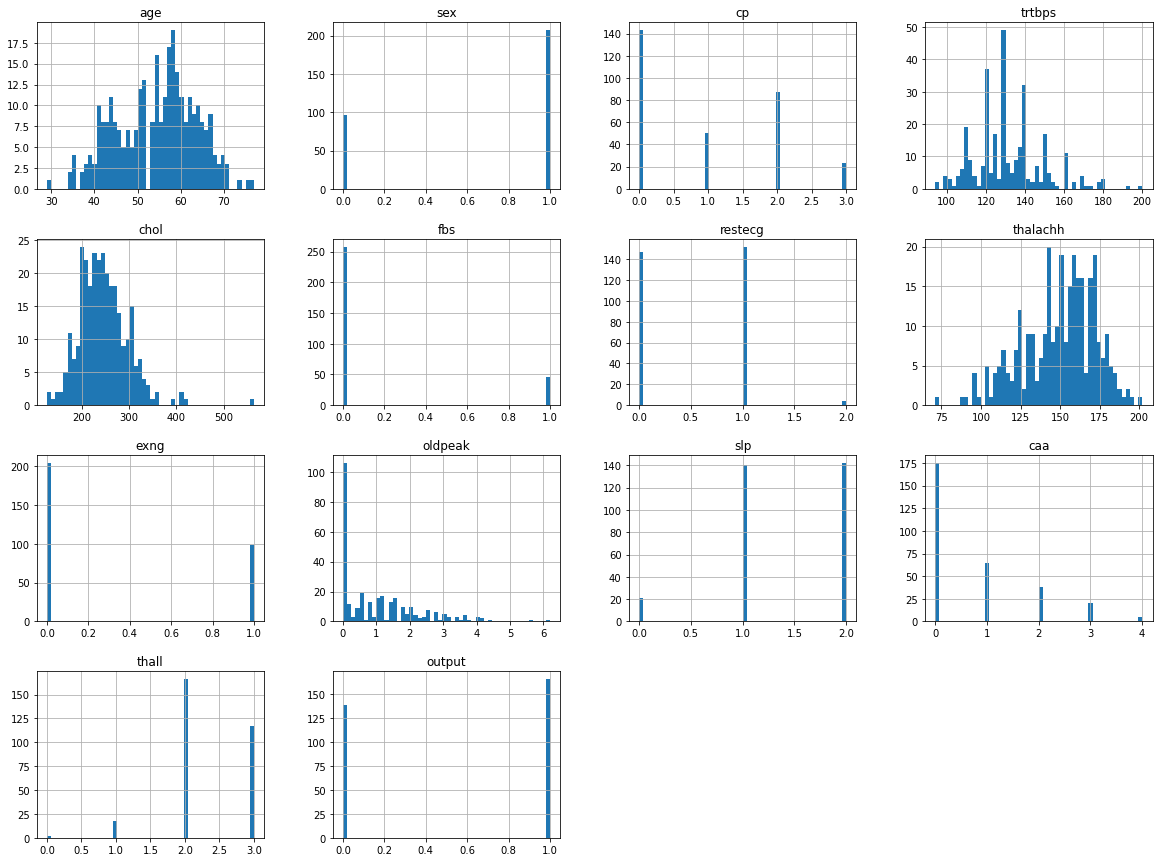

In [77]:
_ = balanced_dataset.hist(bins=50, figsize=(20,15))

'sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall' appear to be numerical features but they are categorical features.
For other features, it seems that data is skewed so there is a possibility of outliers present. We will explore this further in the next section.


In [78]:
numerical_features=['age','trtbps','chol','thalachh','oldpeak']
categorical_features=['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']

# Exploring the Numerical Features

Lets visualize the numerical data with the help of boxplots to get some insights about outliers and quartiles.

<AxesSubplot:>

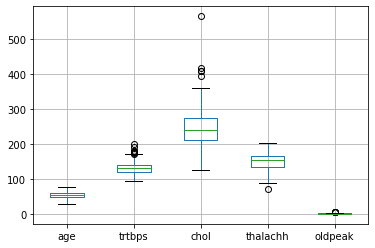

In [79]:
balanced_dataset[numerical_features].boxplot()

<AxesSubplot:xlabel='age'>

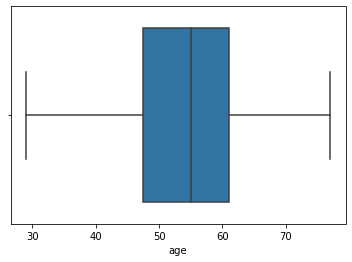

In [80]:
sns.boxplot(x='age', data=balanced_dataset)

Appearantly, the age feature has no outliers.

<AxesSubplot:xlabel='trtbps'>

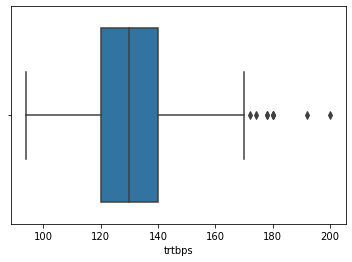

In [81]:
sns.boxplot(x='trtbps', data=balanced_dataset)

For trtbph(resting blood pressure) feature, there are 6 outliers whose value appear to be greater than 170.

<AxesSubplot:xlabel='chol'>

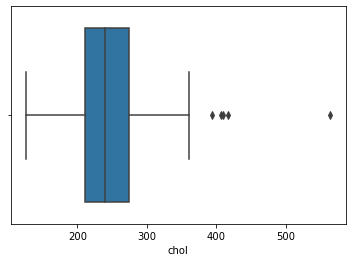

In [82]:
sns.boxplot(x='chol', data=balanced_dataset)

For cholesterol(chol), there are 5 outliers whose value appear to be greater than 360.

<AxesSubplot:xlabel='thalachh'>

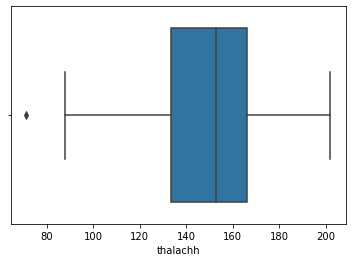

In [83]:
sns.boxplot(x='thalachh', data=balanced_dataset)

For feaure maximum heart rate achieved(thalachh), there is only one outlier whose value appear to be less than 75.

<AxesSubplot:xlabel='oldpeak'>

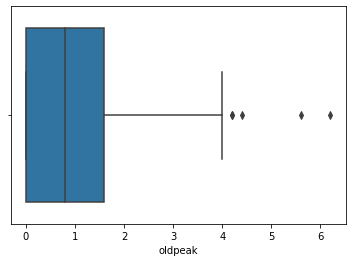

In [84]:
sns.boxplot(x='oldpeak', data=balanced_dataset)

For feature old peak, there are 4 outliers having value greater than 4.

Although outliers exist in our continuous data, but we are not going to remove them as those values are realistic values. For example, cholesterol reaching above 400 in very rare but it happens under different medical circumstances.

Lets, check the correlations among the numerical features with the help of a heat map.

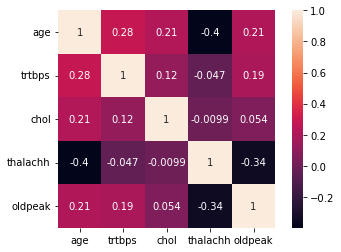

In [85]:
corr = balanced_dataset[numerical_features].corr()
sns.heatmap(corr, annot=True, square=True)
plt.yticks(rotation=0)
plt.show()

Thalachh(max heart rate achieved) has a weak negative correlation with all other features.
While oldpeak, cholesterol, trtbps(resting bloodpressure) and age have weak positive correlations among each other.
We can verify this through relational plots.

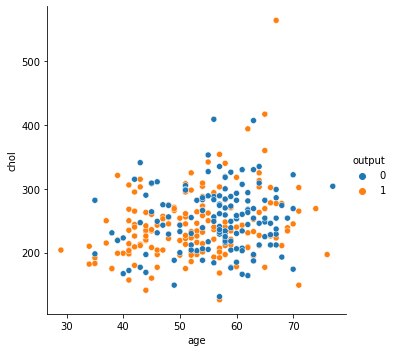

In [86]:
sns.relplot(x='age', y='chol', hue='output', data=balanced_dataset)

The above graph gives no significant insights about the relation between chol and age because both are weakly corelated as discussed earlier.

# Exploring the Categorical Features

Displaying the distribution of categorical features among both classes in terms of percentage.

https://medium.com/swlh/how-to-create-percentage-plots-for-visualizing-your-data-in-python-f0d894d7c7bb

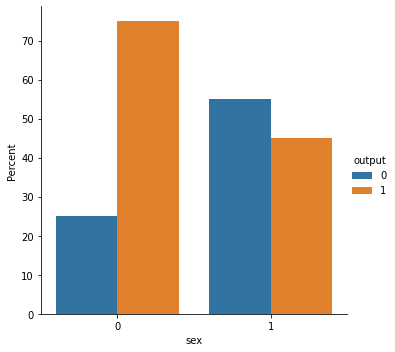

In [87]:
df_temp = balanced_dataset.groupby('sex')['output'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='sex', y='Percent', hue='output', kind='bar', data=df_temp)

Insight from above graph: Chances of heart attack in females(0) is higher than males(1).

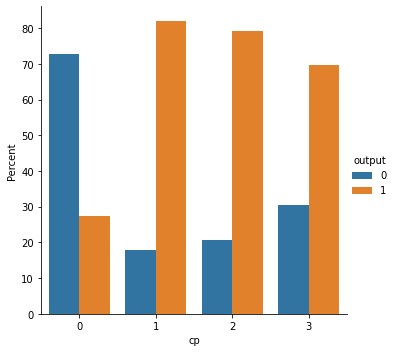

In [88]:
df_temp = balanced_dataset.groupby('cp')['output'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='cp', y='Percent', hue='output', kind='bar', data=df_temp)

Insight: Chances of heartattack are high with chest pains (atypical angina(1), non-anginal pain(2) and asympmtomatic pain(3)).

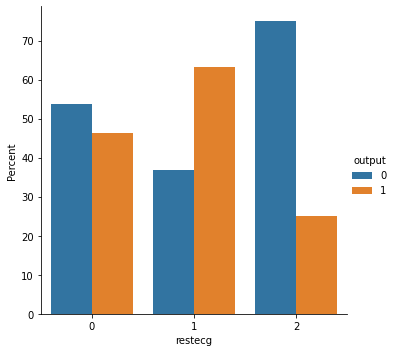

In [89]:
df_temp = balanced_dataset.groupby('restecg')['output'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='restecg', y='Percent', hue='output', kind='bar', data=df_temp)

With Restingelectrocardiographic results of type1, chances of heartattack are high, with type 0 they are moderate while with type 2 they are really low.

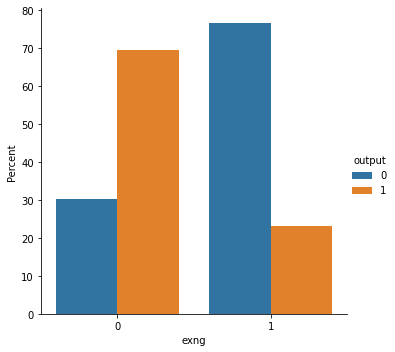

In [90]:
df_temp = balanced_dataset.groupby('exng')['output'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='exng', y='Percent', hue='output', kind='bar', data=df_temp)

Surprisingly, with Exercise Induced Angina, chances of heartattack are low.

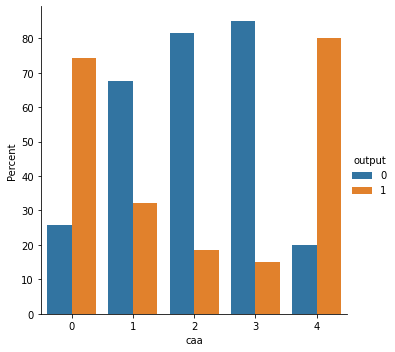

In [91]:
df_temp = balanced_dataset.groupby('caa')['output'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='caa', y='Percent', hue='output', kind='bar', data=df_temp)

People with 0 and 4 major vessels have more chances of getting a heart attack.

# Data pre-processing

In [92]:
print("Number of rows before dropping duplicates: %d" % len(balanced_dataset))
balanced_dataset= balanced_dataset.drop_duplicates()
print("Number of rows after dropping duplicates: %d" % len(balanced_dataset))

Number of rows before dropping duplicates: 303
Number of rows after dropping duplicates: 302


As visualized earlier, they was 1 duplicate rows in the dataset so we have removed it.

As, we are going to perform random forest in our baseline model, so no feature scaling or features reduction is required.

In [93]:
X_balanced_dataset=balanced_dataset.drop(columns=['output'])
Y_balanced_dataset=balanced_dataset['output'].copy()

# Creating a Surrogate achieving low Imbalance

In [94]:
L=balanced_dataset[balanced_dataset['output'] == 0] 
M=balanced_dataset[balanced_dataset['output'] == 1] #majority class more chances of heartattack represented by 1
L= L.sample(replace=False,  n=88, random_state=1) #minority class less chances of heartattack represented by 0
Imbalanced_dataset_low=pd.concat([M, L])
Imbalanced_dataset_low.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [95]:
M=(Imbalanced_dataset_low['output'].value_counts()[1])/(len(Imbalanced_dataset_low))*100
print('percentage of output with more chances of heart attack: ',round(M))
L=Imbalanced_dataset_low['output'].value_counts()[0]/(len(Imbalanced_dataset_low))*100
print('percentage of output with less chances of heartattack: ',round(L))

percentage of output with more chances of heart attack:  65
percentage of output with less chances of heartattack:  35


<AxesSubplot:xlabel='output', ylabel='count'>

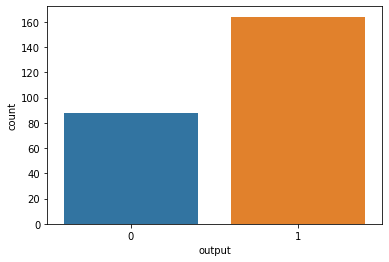

In [96]:
sns.countplot(x="output", data=Imbalanced_dataset_low)

In [97]:
Imbalanced_dataset_low.shape

(252, 14)

Low Surrogate dataset has 252 rows and same number of columns as in balanced dataset.

In [98]:
print('Duplicates in the dataset: ', Imbalanced_dataset_low.duplicated().sum())

Duplicates in the dataset:  0


Duplicates are checked to ensure that there was no duplication while randomly sub-sampling from the e class.

In [99]:
X_Imbalanced_dataset_low=Imbalanced_dataset_low.drop(columns=['output'])
Y_Imbalanced_dataset_low=Imbalanced_dataset_low['output'].copy()

Features and target label are separated in the above piece of code.

# Creating a Surrogate achieving Medium Imbalance

In [100]:
L=balanced_dataset[balanced_dataset['output'] == 0] 
M=balanced_dataset[balanced_dataset['output'] == 1] #majority class more chances of heartattack represented by 1
L= L.sample(replace=False,  n=54, random_state=1) #minority class less chances of heartattack represented by 0
Imbalanced_dataset_med=pd.concat([M, L])
Imbalanced_dataset_med.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [101]:
M=(Imbalanced_dataset_med['output'].value_counts()[1])/(len(Imbalanced_dataset_med))*100
print('percentage of output with more chances of heart attack: ',round(M))
L=Imbalanced_dataset_med['output'].value_counts()[0]/(len(Imbalanced_dataset_med))*100
print('percentage of output with less chances of heartattack: ',round(L))

percentage of output with more chances of heart attack:  75
percentage of output with less chances of heartattack:  25


<AxesSubplot:xlabel='output', ylabel='count'>

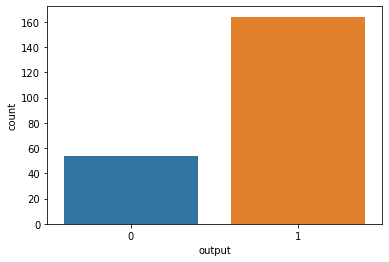

In [102]:
sns.countplot(x="output", data=Imbalanced_dataset_med)

In [103]:
Imbalanced_dataset_med.shape

(218, 14)

Med Surrogate dataset has 218 rows and same number of columns as in balanced dataset.

In [104]:
print('Duplicates in the dataset: ', Imbalanced_dataset_med.duplicated().sum())

Duplicates in the dataset:  0


Duplicates are checked to ensure that there was no duplication while randomly sub-sampling from the e class.

In [105]:
X_Imbalanced_dataset_med=Imbalanced_dataset_med.drop(columns=['output'])
Y_Imbalanced_dataset_med=Imbalanced_dataset_med['output'].copy()

Features and target label are separated in the above piece of code.

# Creating a Surrogate achieving High Imbalance

In [106]:
L=balanced_dataset[balanced_dataset['output'] == 0] 
M=balanced_dataset[balanced_dataset['output'] == 1] #majority class more chances of heartattack represented by 1
L= L.sample(replace=False,  n=18, random_state=1) #minority class less chances of heartattack represented by 0
Imbalanced_dataset_high=pd.concat([M, L])
Imbalanced_dataset_high.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [107]:
M=(Imbalanced_dataset_high['output'].value_counts()[1])/(len(Imbalanced_dataset_high))*100
print('percentage of output with more chances of heart attack: ',round(M))
L=Imbalanced_dataset_high['output'].value_counts()[0]/(len(Imbalanced_dataset_high))*100
print('percentage of output with less chances of heartattack: ',round(L))

percentage of output with more chances of heart attack:  90
percentage of output with less chances of heartattack:  10


<AxesSubplot:xlabel='output', ylabel='count'>

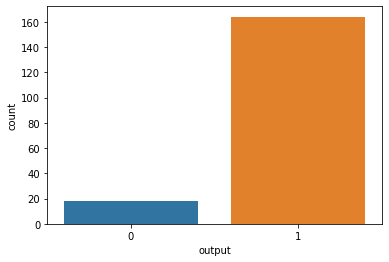

In [108]:
sns.countplot(x="output", data=Imbalanced_dataset_high)

In [109]:
Imbalanced_dataset_high.shape

(182, 14)

Med Surrogate dataset has 182 rows and same number of columns as in balanced dataset.

In [110]:
print('Duplicates in the dataset: ', Imbalanced_dataset_high.duplicated().sum())

Duplicates in the dataset:  0


Duplicates are checked to ensure that there was no duplication while randomly sub-sampling from the e class.

In [111]:
X_Imbalanced_dataset_high=Imbalanced_dataset_high.drop(columns=['output'])
Y_Imbalanced_dataset_high=Imbalanced_dataset_high['output'].copy()

Features and target label are separated in the above piece of code.

# Deployment Code

# Baseline Model Implementation

Calling baseline function on balanced dataset

In [113]:
balanced_accuracy_baseline,balanced_f1_baseline,balanced_accuracies_baseline,balanced_f1_scores_baseline=base_model1(X_balanced_dataset,Y_balanced_dataset)

Mean Accuracy : 0.8048387096774193 ,Standard Deviation: 0.07516313625496396
Mean F1 score : 0.8222176631213634 ,Standard Deviation: 0.07119259335912236


Calling baseline function on low imbalanced dataset

In [114]:
low_accuracy_baseline,low_f1_baseline,low_accuracies_baseline,low_f1_scores_baseline=base_model1(X_Imbalanced_dataset_low,Y_Imbalanced_dataset_low)

Mean Accuracy : 0.8256923076923077 ,Standard Deviation: 0.07065559438396567
Mean F1 score : 0.8692170484082249 ,Standard Deviation: 0.05522272037674967


calling baseline function on medium imbalanced dataset

In [115]:
med_accuracy_baseline,med_f1_baseline,med_accuracies_baseline,med_f1_scores_baseline=base_model1(X_Imbalanced_dataset_med,Y_Imbalanced_dataset_med)

Mean Accuracy : 0.8673160173160174 ,Standard Deviation: 0.06829030056002196
Mean F1 score : 0.9160187699158288 ,Standard Deviation: 0.04235938754579031


calling baseline function on highly imbalanced dataset

In [116]:
high_accuracy_baseline,high_f1_baseline,high_accuracies_baseline,high_f1_scores_baseline=base_model1(X_Imbalanced_dataset_med,Y_Imbalanced_dataset_med)

Mean Accuracy : 0.8673160173160174 ,Standard Deviation: 0.07683250986441705
Mean F1 score : 0.9160833866716219 ,Standard Deviation: 0.04837347577739158


# Proposed Model Implementation

calling ensembled model function on balanced dataset

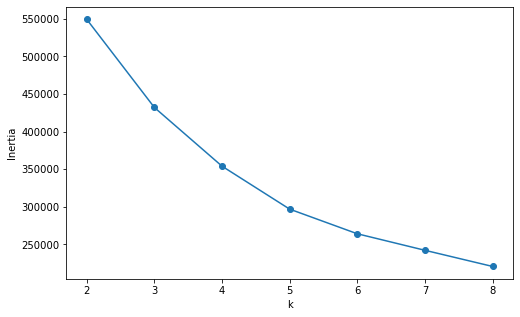

Enter the best possible value of k from elbow graph:5


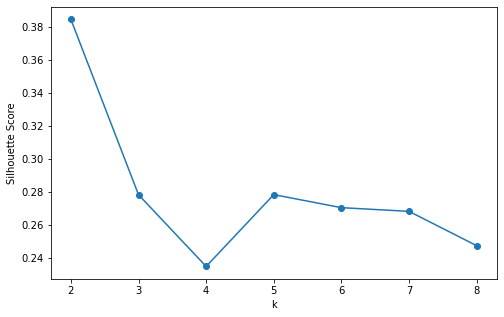

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0]


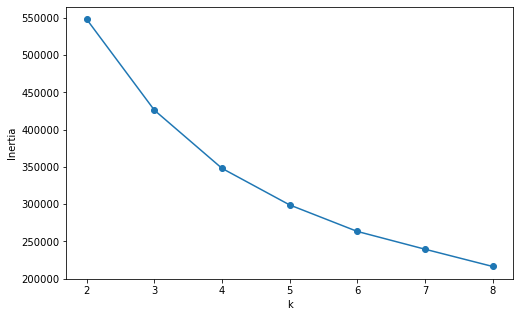

Enter the best possible value of k from elbow graph:4


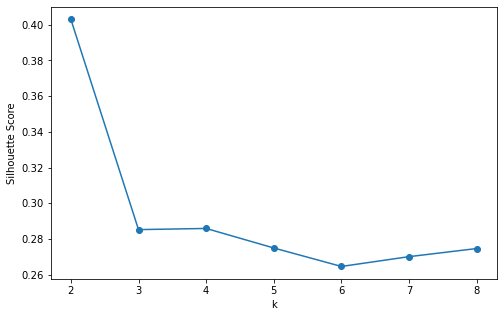

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1]


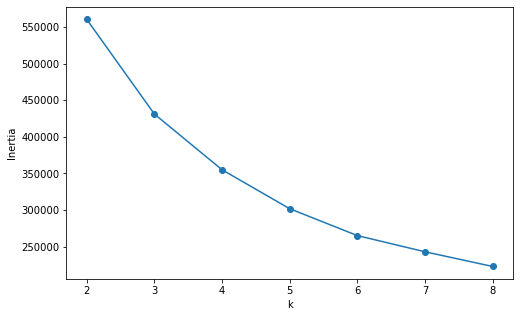

Enter the best possible value of k from elbow graph:5


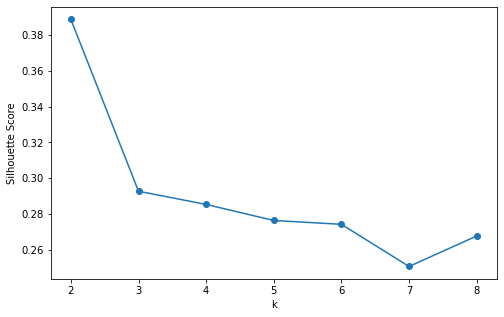

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0]


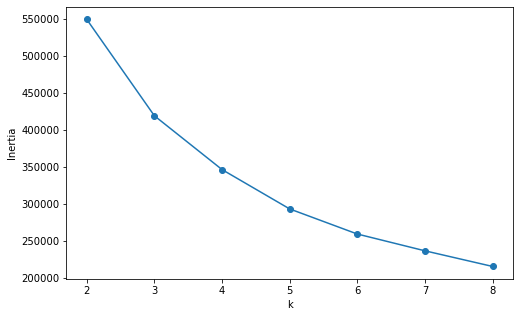

Enter the best possible value of k from elbow graph:5


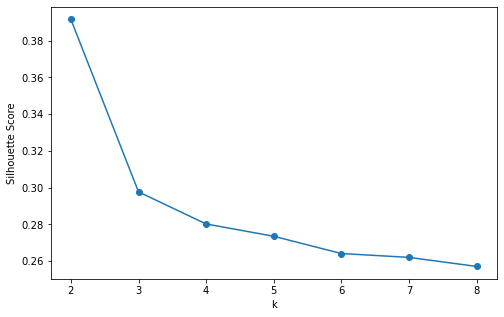

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0]


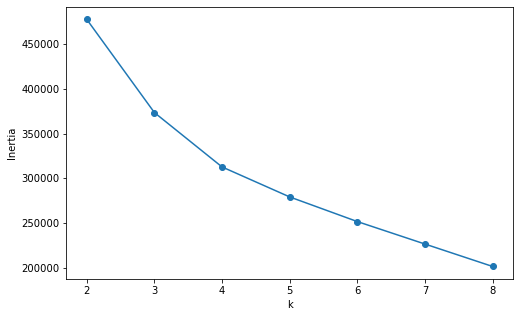

Enter the best possible value of k from elbow graph:4


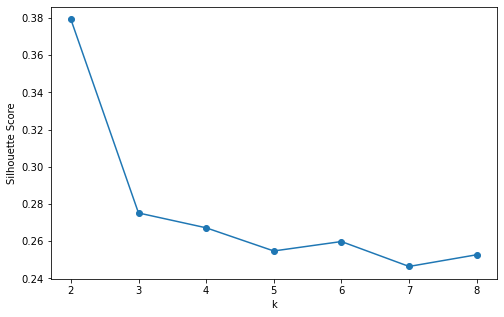

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0]


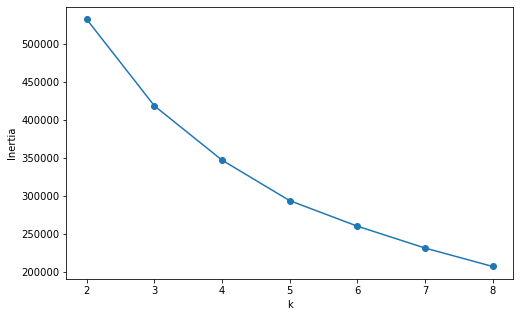

Enter the best possible value of k from elbow graph:5


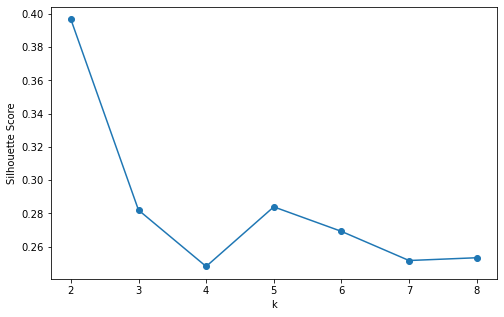

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0]


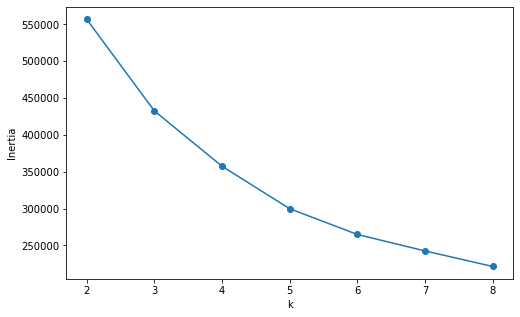

Enter the best possible value of k from elbow graph:5


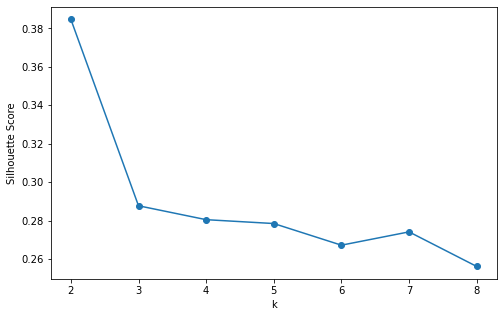

Enter the best possible value of k from silhoutte graph:2
[1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


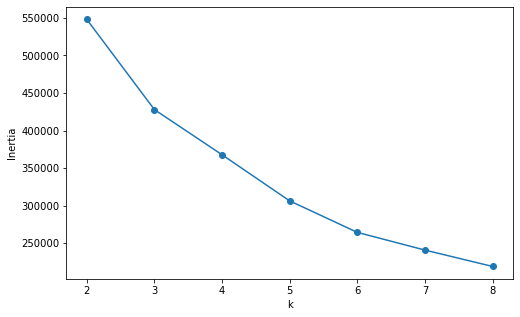

Enter the best possible value of k from elbow graph:5


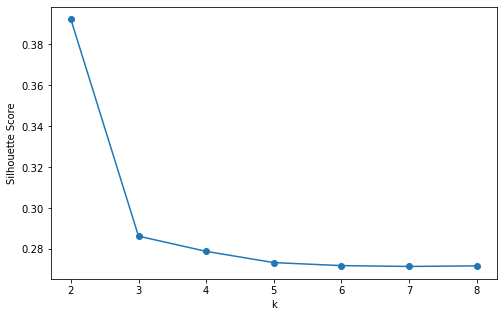

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1]


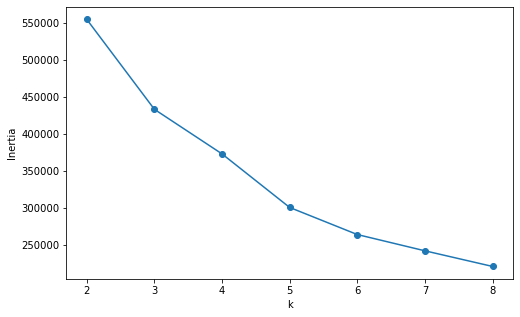

Enter the best possible value of k from elbow graph:5


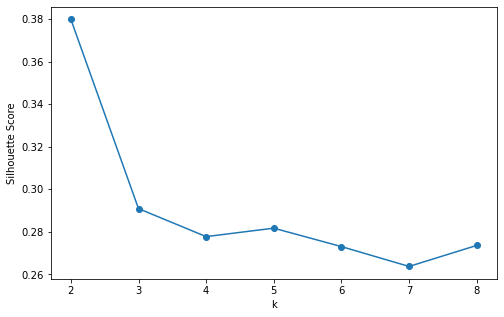

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1]


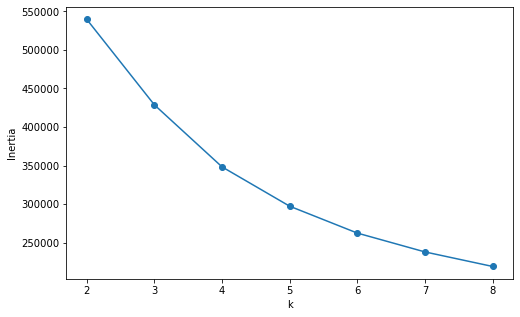

Enter the best possible value of k from elbow graph:5


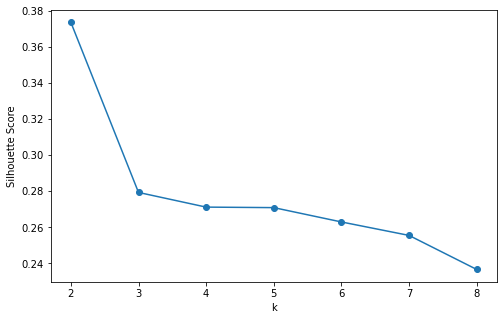

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0]
Mean Accuracy : 0.8078494623655914 ,Standard Deviation: 0.038841025663571505
Mean F1 score : 0.8281870556064104 ,Standard Deviation: 0.04047160413267273


In [117]:
balanced_accuracy_ensemble,balanced_f1_ensemble,balanced_accuracies_ensemble,balanced_f1_scores_ensemble=ensemble_model(X_balanced_dataset,Y_balanced_dataset)

calling ensembled model function on low imbalanced dataset

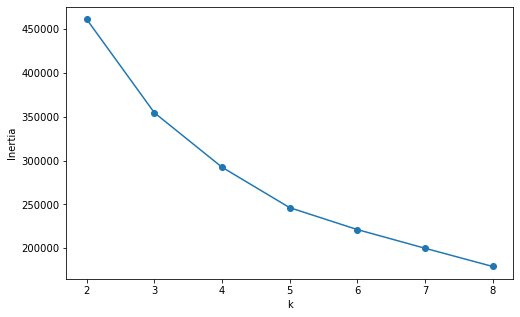

Enter the best possible value of k from elbow graph:5


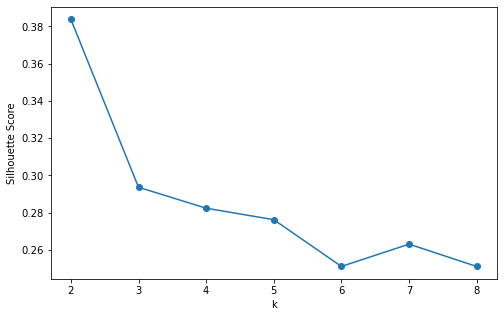

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0]


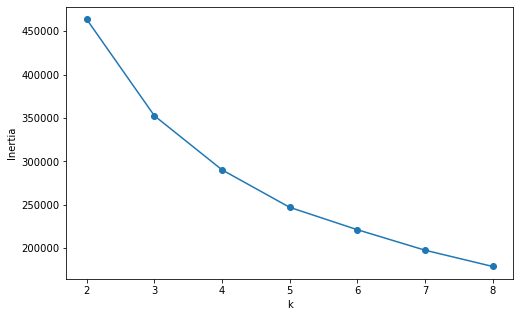

Enter the best possible value of k from elbow graph:5


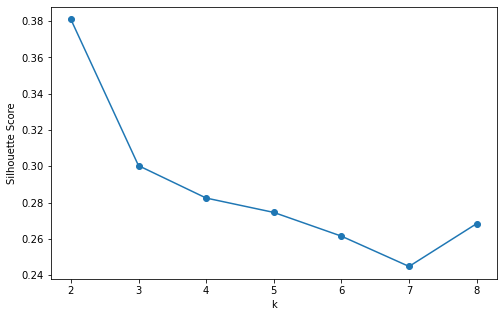

Enter the best possible value of k from silhoutte graph:2
[0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0]


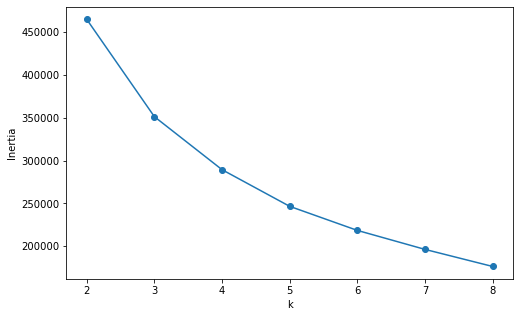

Enter the best possible value of k from elbow graph:3


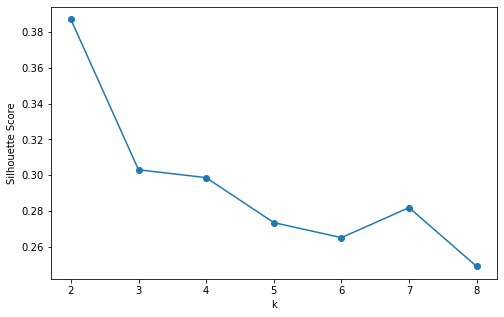

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1]


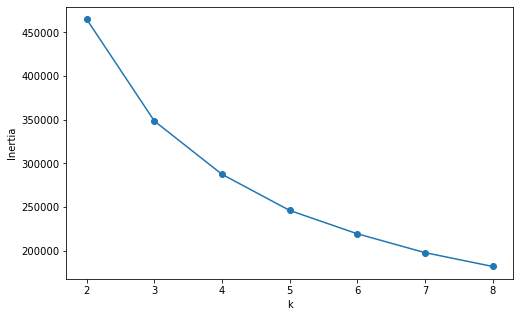

Enter the best possible value of k from elbow graph:3


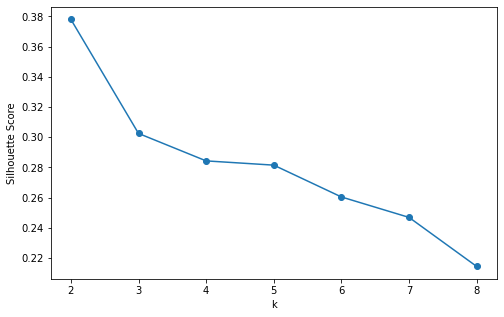

Enter the best possible value of k from silhoutte graph:2
[1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0]


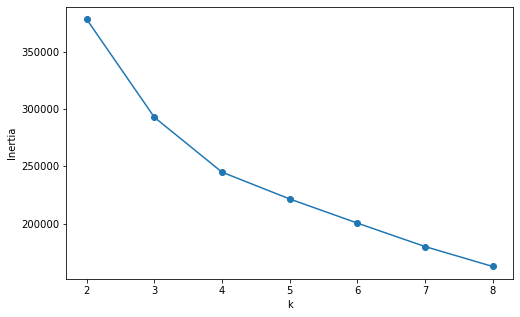

Enter the best possible value of k from elbow graph:4


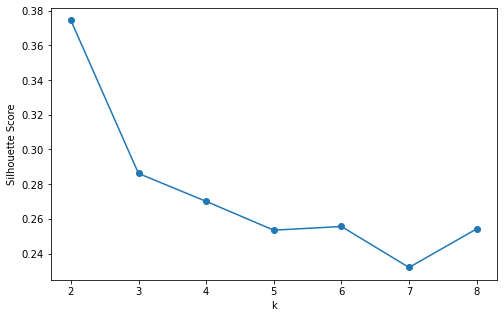

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0]


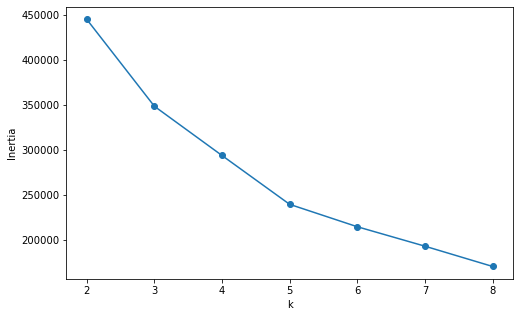

Enter the best possible value of k from elbow graph:5


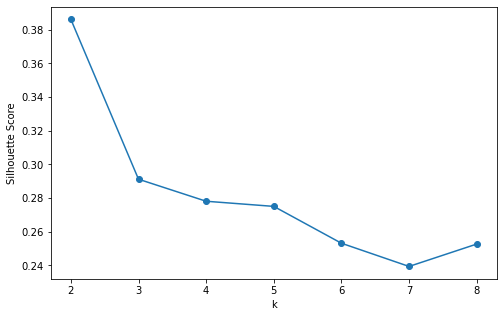

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


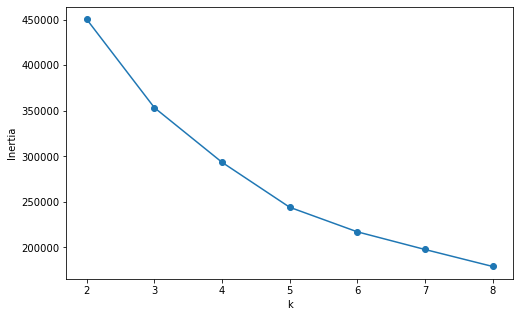

Enter the best possible value of k from elbow graph:5


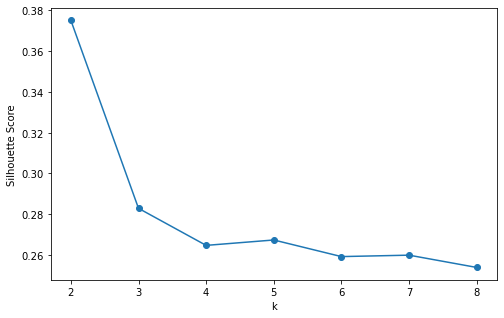

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0]


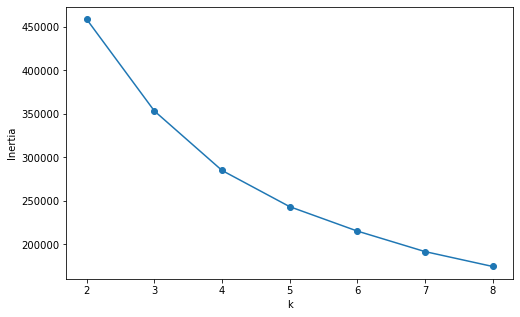

Enter the best possible value of k from elbow graph:5


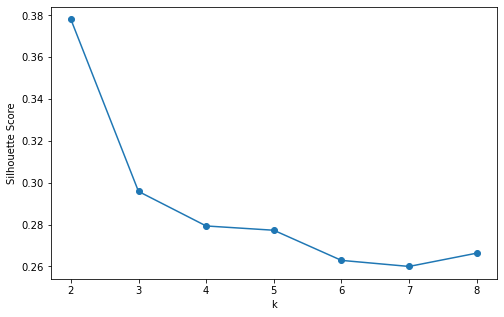

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1]


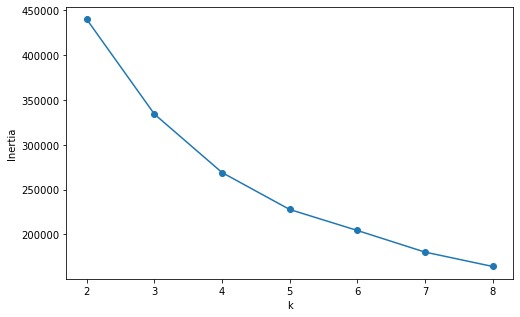

Enter the best possible value of k from elbow graph:5


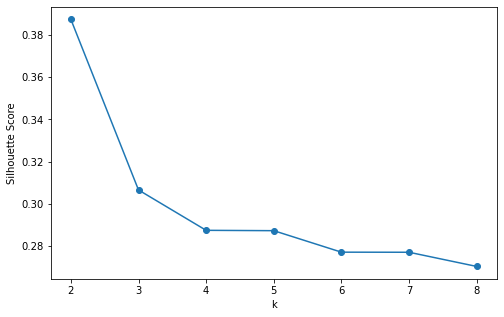

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1]


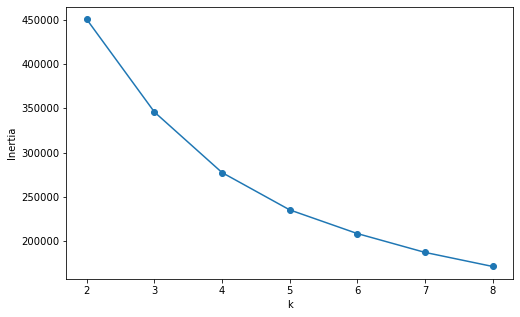

Enter the best possible value of k from elbow graph:5


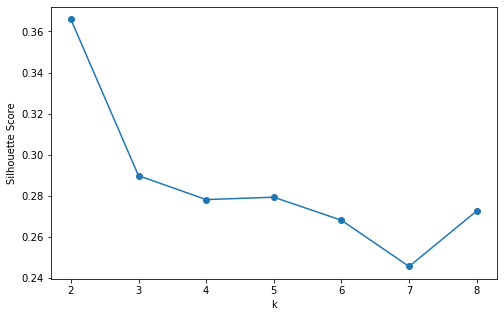

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0]
Mean Accuracy : 0.8172307692307692 ,Standard Deviation: 0.0653069221663388
Mean F1 score : 0.8689620787153994 ,Standard Deviation: 0.04240256232842398


In [119]:
low_accuracy_ensemble,low_f1_ensemble,low_accuracies_ensemble,low_f1_scores_ensemble=ensemble_model(X_Imbalanced_dataset_low,Y_Imbalanced_dataset_low)

calling ensembled model function on medium imbalanced dataset

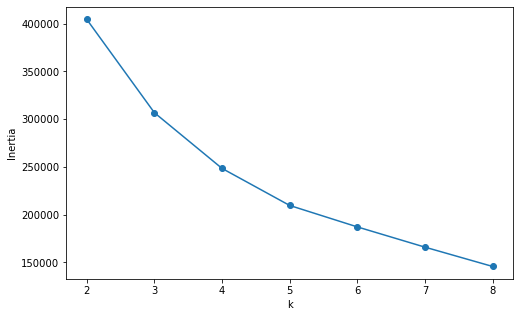

Enter the best possible value of k from elbow graph:5


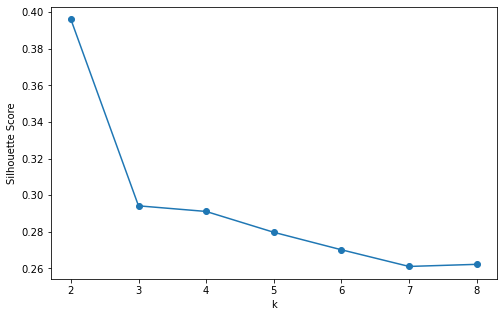

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1]


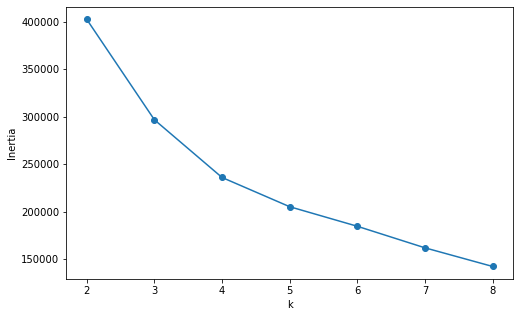

Enter the best possible value of k from elbow graph:4


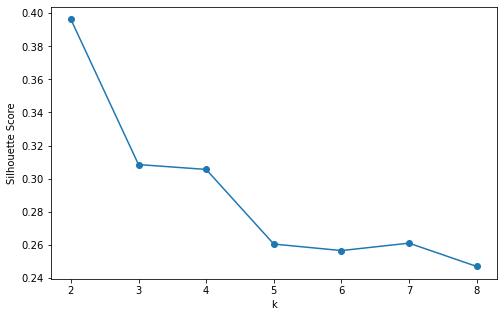

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0]


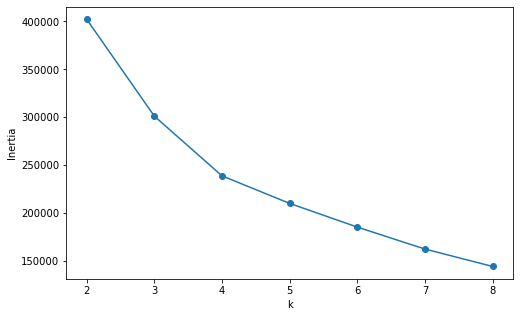

Enter the best possible value of k from elbow graph:4


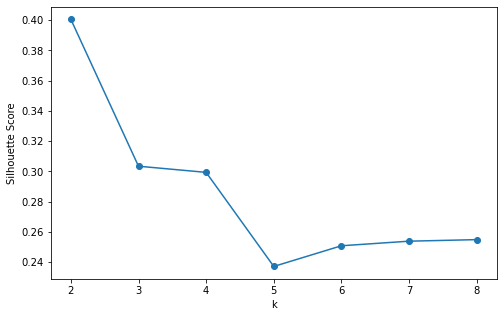

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0]


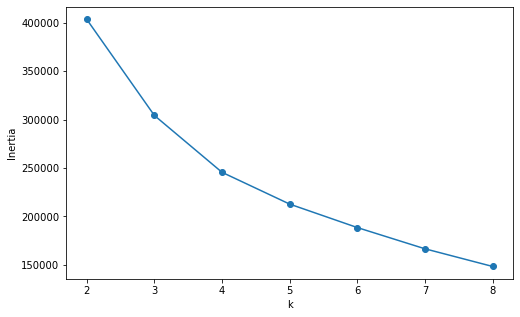

Enter the best possible value of k from elbow graph:4


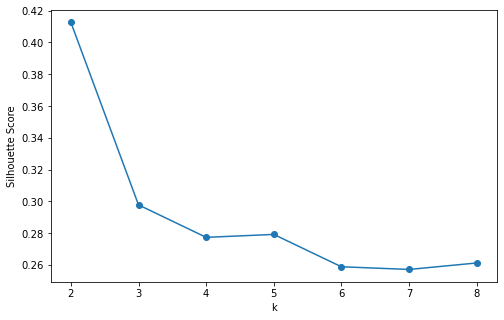

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1]


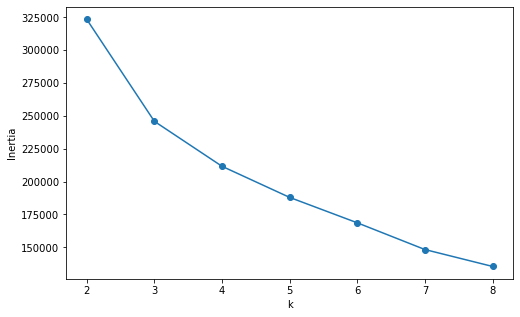

Enter the best possible value of k from elbow graph:3


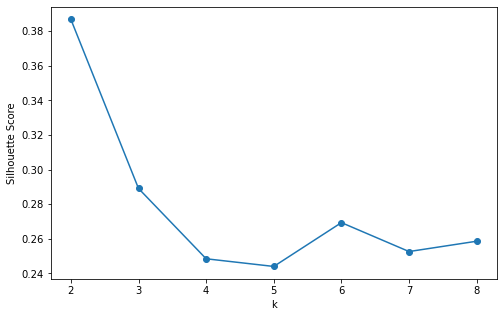

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1]


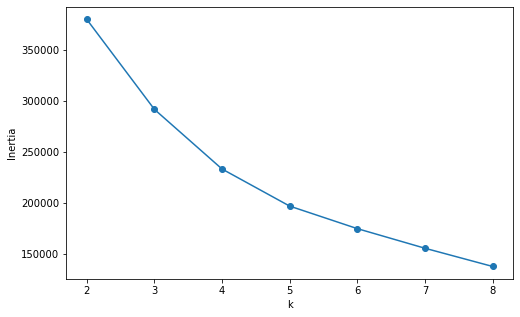

Enter the best possible value of k from elbow graph:4


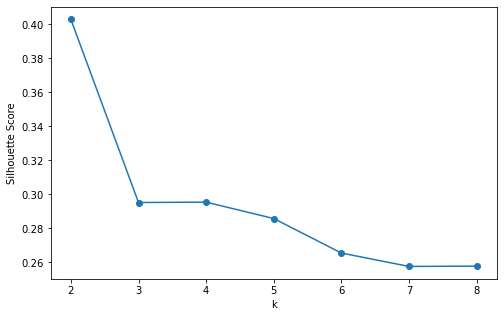

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1]


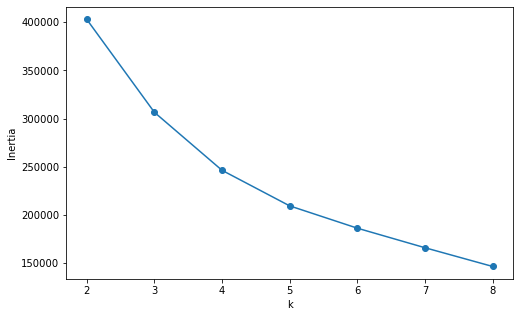

Enter the best possible value of k from elbow graph:4


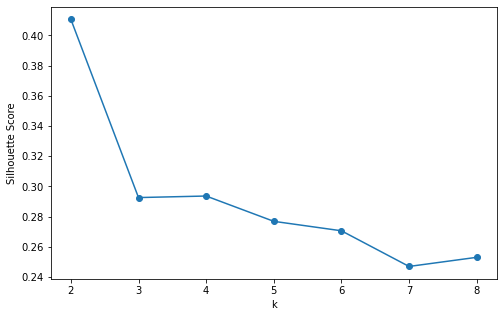

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


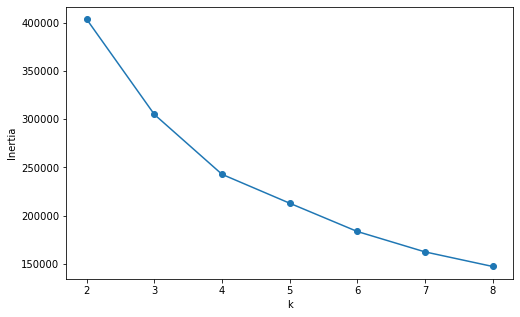

Enter the best possible value of k from elbow graph:4


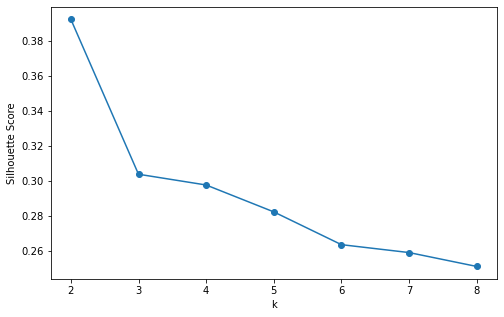

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


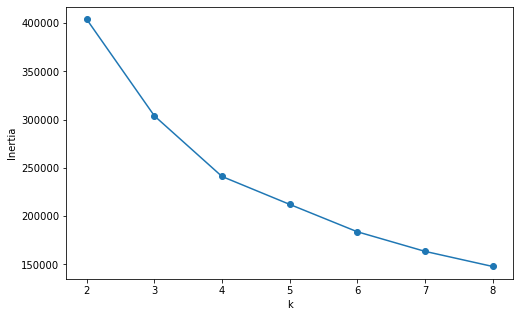

Enter the best possible value of k from elbow graph:4


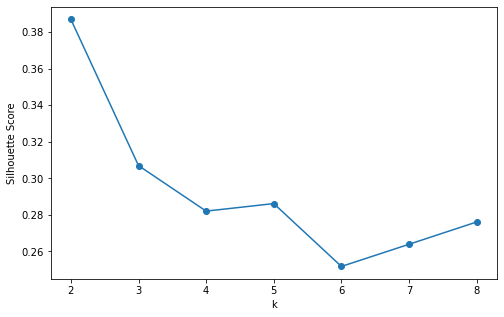

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]


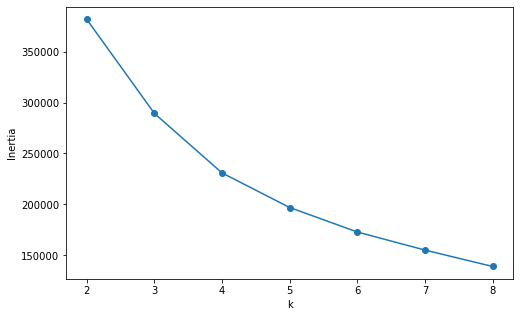

Enter the best possible value of k from elbow graph:4


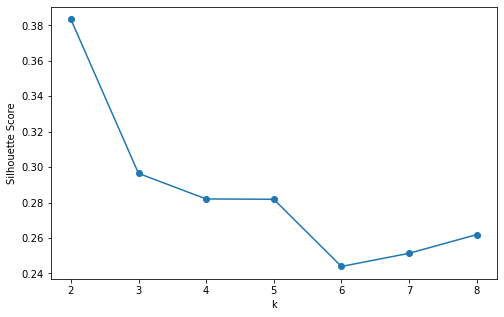

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1]
Mean Accuracy : 0.8216450216450216 ,Standard Deviation: 0.06149776906650696
Mean F1 score : 0.8898729286964581 ,Standard Deviation: 0.03797695393508082


In [120]:
med_accuracy_ensemble,med_f1_ensemble,med_accuracies_ensemble,med_f1_scores_ensemble=ensemble_model(X_Imbalanced_dataset_med,Y_Imbalanced_dataset_med)

calling ensembled model function on high imbalanced dataset

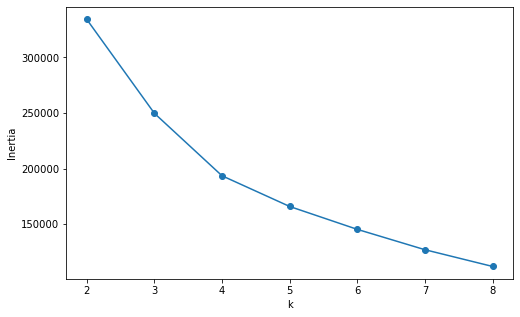

Enter the best possible value of k from elbow graph:4


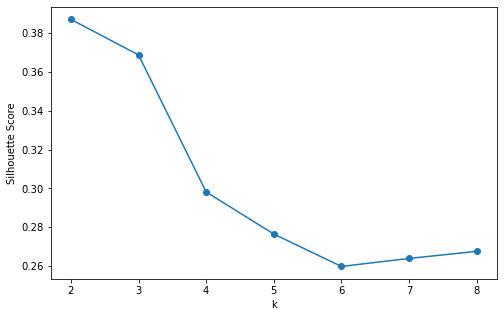

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


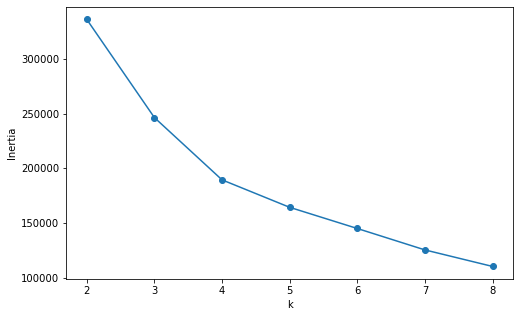

Enter the best possible value of k from elbow graph:4


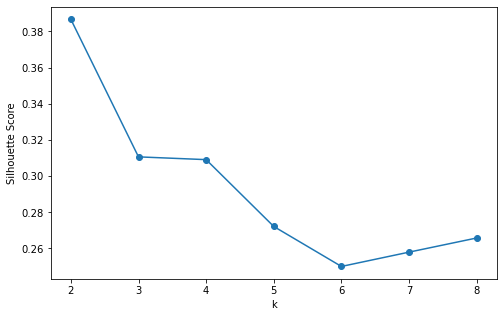

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


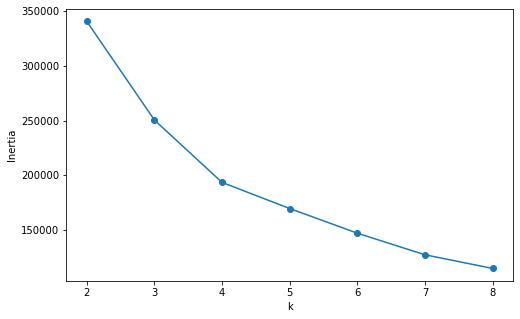

Enter the best possible value of k from elbow graph:4


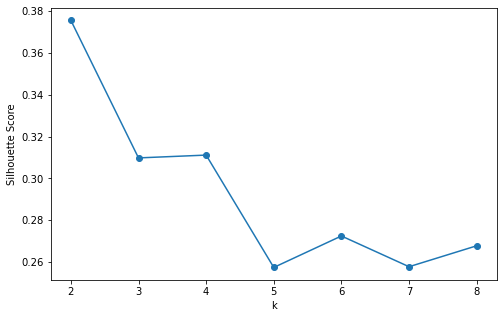

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


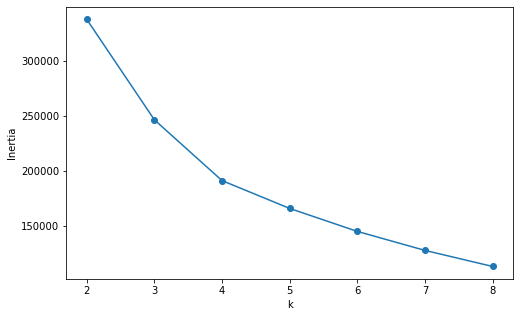

Enter the best possible value of k from elbow graph:4


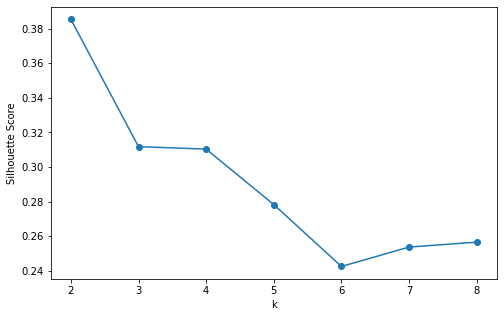

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


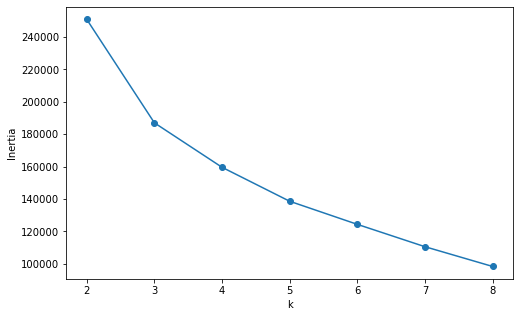

Enter the best possible value of k from elbow graph:3


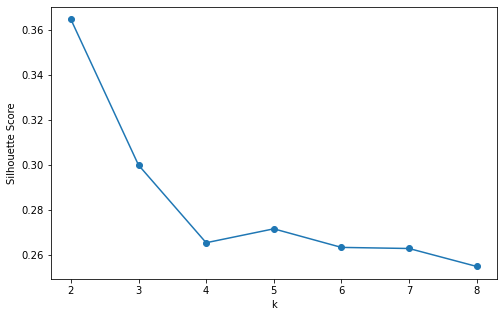

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


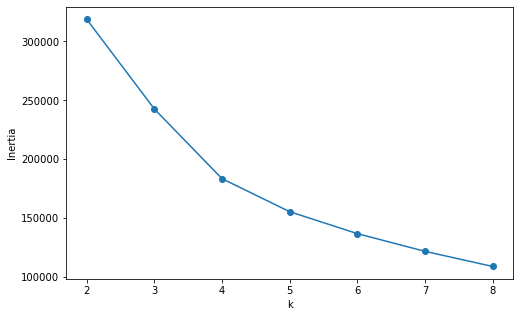

Enter the best possible value of k from elbow graph:4


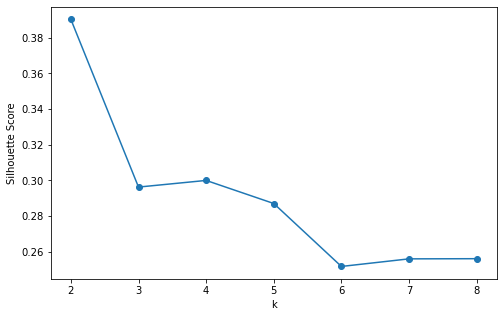

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


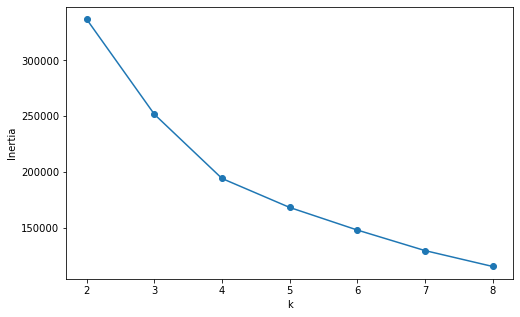

Enter the best possible value of k from elbow graph:4


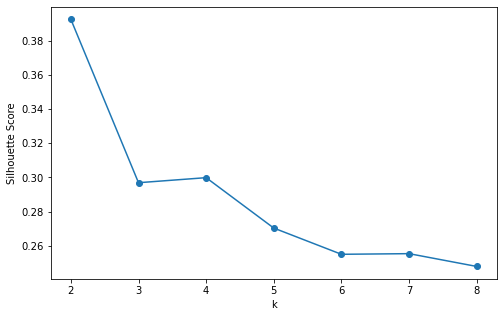

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


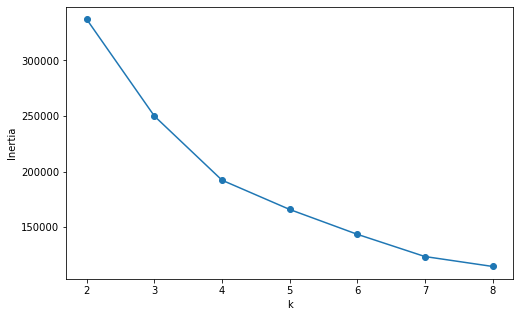

Enter the best possible value of k from elbow graph:4


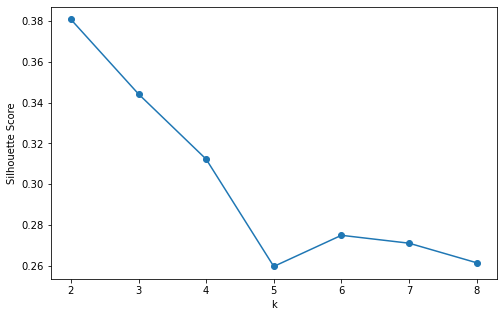

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


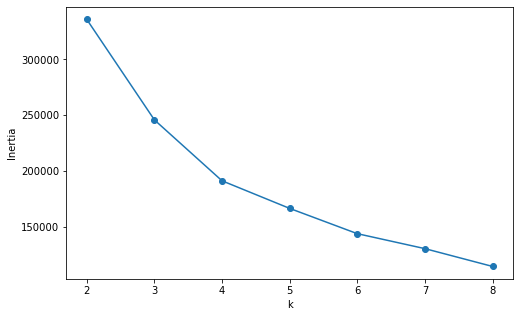

Enter the best possible value of k from elbow graph:4


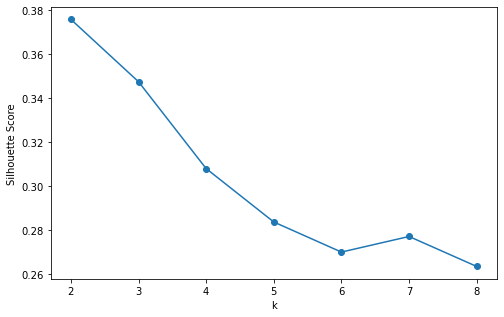

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


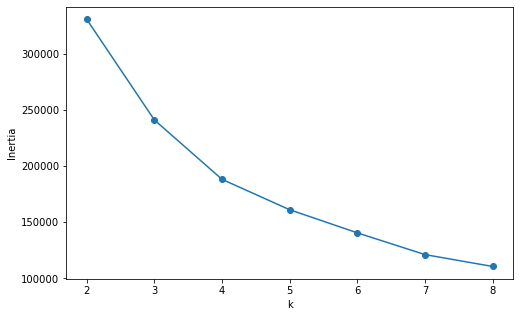

Enter the best possible value of k from elbow graph:4


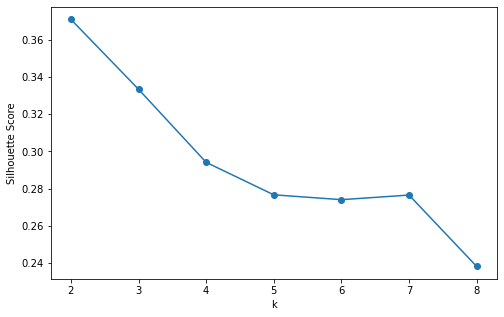

Enter the best possible value of k from silhoutte graph:2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mean Accuracy : 0.9122807017543859 ,Standard Deviation: 0.026348258072675584
Mean F1 score : 0.9534114251761311 ,Standard Deviation: 0.013710814644137113


In [121]:
high_accuracy_ensemble,high_f1_ensemble,high_accuracies_ensemble,high_f1_scores_ensemble=ensemble_model(X_Imbalanced_dataset_high,Y_Imbalanced_dataset_high)

calling ensembled model function on low imbalanced dataset

# Comparing Baseline and Proposed Method Results

# Comparison Table For Accuracies and F1 scores

In [136]:
from prettytable import PrettyTable
 
myTable = PrettyTable(["Model", "Data Imabalance", "Accuracy", "F1 Score"])
 
# Add rows
myTable.add_row(["Baseline", "Balanced", round(balanced_accuracy_baseline,2), round(balanced_f1_baseline,2)])
myTable.add_row(["Baseline", "Low Imbalanced", round(low_accuracy_baseline,2), round(low_f1_baseline,2)])
myTable.add_row(["Baseline", "Medium Imbalanced", round(med_accuracy_baseline,2),round(med_f1_baseline,2)])
myTable.add_row(["Baseline", "High Imbalanced", round(high_accuracy_baseline,2), round(high_f1_baseline,2)])
myTable.add_row(["Ensembled", "Balanced", round(balanced_accuracy_ensemble,2), round(balanced_f1_ensemble,2)])
myTable.add_row(["Ensembled", "Low Imbalanced", round(low_accuracy_ensemble,2), round(low_f1_ensemble,2)])
myTable.add_row(["Ensembled", "Medium Imbalanced", round(med_accuracy_ensemble,2), round(med_f1_ensemble,2)])
myTable.add_row(["Ensembled", "High Imbalanced", round(high_accuracy_ensemble,2), round(high_f1_ensemble,2)]) 
print(myTable)

+-----------+-------------------+----------+----------+
|   Model   |  Data Imabalance  | Accuracy | F1 Score |
+-----------+-------------------+----------+----------+
|  Baseline |      Balanced     |   0.8    |   0.82   |
|  Baseline |   Low Imbalanced  |   0.83   |   0.87   |
|  Baseline | Medium Imbalanced |   0.87   |   0.92   |
|  Baseline |  High Imbalanced  |   0.87   |   0.92   |
| Ensembled |      Balanced     |   0.81   |   0.83   |
| Ensembled |   Low Imbalanced  |   0.82   |   0.87   |
| Ensembled | Medium Imbalanced |   0.82   |   0.89   |
| Ensembled |  High Imbalanced  |   0.91   |   0.95   |
+-----------+-------------------+----------+----------+


# Permutation Tests

Permutation test for accuracies of balanced datasets for baseline and proposed models

In [123]:
bal_acc_p=permut_test(balanced_accuracies_baseline,balanced_accuracies_ensemble,balanced_accuracy_baseline,balanced_accuracy_ensemble, 70000)
print(bal_acc_p)

0.4548857142857143


Permutation test for accuracies of low imbalanced datasets for baseline and proposed models

In [124]:
low_acc_p=permut_test(low_accuracies_baseline,low_accuracies_ensemble,low_accuracy_baseline,low_accuracy_ensemble, 70000)
print(low_acc_p)

0.6100571428571429


Permutation test for accuracies of med imbalanced datasets for baseline and proposed models

In [125]:
med_acc_p=permut_test(med_accuracies_baseline,med_accuracies_ensemble,med_accuracy_baseline,med_accuracy_ensemble, 70000)
print(med_acc_p)

0.9250142857142857


Permutation test for accuracies of high imbalanced datasets for baseline and proposed models

In [126]:
high_acc_p=permut_test(high_accuracies_baseline,high_accuracies_ensemble,high_accuracy_baseline,high_accuracy_ensemble, 70000)
print(high_acc_p)

0.05317142857142857


Permutation test for f1 scores of balanced datasets for baseline and proposed models

In [127]:
bal_f1_p=permut_test(balanced_f1_scores_baseline,balanced_f1_scores_ensemble,balanced_f1_baseline,balanced_f1_ensemble, 70000)
print(bal_f1_p)

0.41391428571428573


Permutation test for f1 scores of low imbalanced datasets for baseline and proposed models

In [128]:
low_f1_p=permut_test(low_f1_scores_baseline,low_f1_scores_ensemble,low_f1_baseline,low_f1_ensemble, 70000)
print(low_f1_p)

0.5034857142857143


Permutation test for f1 scores of med imbalanced datasets for baseline and proposed models

In [129]:
med_f1_p=permut_test(med_f1_scores_baseline,med_f1_scores_ensemble,med_f1_baseline,med_f1_ensemble, 70000)
print(med_f1_p)

0.9011


Permutation test for f1 scores of high imbalanced datasets for baseline and proposed models

In [130]:
high_f1_p=permut_test(high_f1_scores_baseline,high_f1_scores_ensemble,high_f1_baseline,high_f1_ensemble, 70000)
print(high_f1_p)

0.008528571428571429


Table comparing the Permutation test values for basline and proposed models on different datasets

In [138]:
from prettytable import PrettyTable
 
myTable = PrettyTable([ "Data Imabalance", "P_value for Accuracy","P_value for F1"])
 
# Add rows
myTable.add_row(["Balanced", round(bal_acc_p,2),round(bal_f1_p,2)])
myTable.add_row([ "Low Imbalanced", round(low_acc_p,2),round (low_f1_p,2)])
myTable.add_row([ "Medium Imbalanced", round(med_acc_p,2),round( med_f1_p,2)])
myTable.add_row([ "High Imbalanced", round(high_acc_p,2), round (high_f1_p,3)]) 
print(myTable)


+-------------------+----------------------+----------------+
|  Data Imabalance  | P_value for Accuracy | P_value for F1 |
+-------------------+----------------------+----------------+
|      Balanced     |         0.45         |      0.41      |
|   Low Imbalanced  |         0.61         |      0.5       |
| Medium Imbalanced |         0.93         |      0.9       |
|  High Imbalanced  |         0.05         |     0.009      |
+-------------------+----------------------+----------------+


# Boxplots for accuracies and f1 scores

Boxplot for accuracies

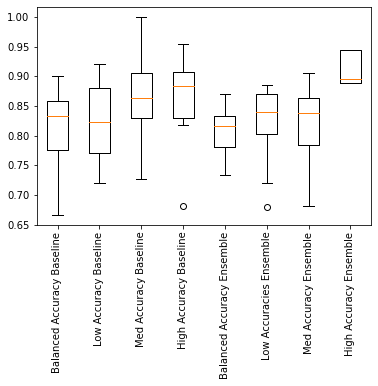

In [132]:
fig, ax = plt.subplots()
labels = ['Balanced Accuracy Baseline','Low Accuracy Baseline', 'Med Accuracy Baseline','High Accuracy Baseline','Balanced Accuracy Ensemble','Low Accuracies Ensemble','Med Accuracy Ensemble','High Accuracy Ensemble' ]
ax.boxplot([balanced_accuracies_baseline,low_accuracies_baseline, med_accuracies_baseline,high_accuracies_baseline,balanced_accuracies_ensemble,low_accuracies_ensemble,med_accuracies_ensemble,high_accuracies_ensemble])
ax.set_xticklabels(labels, rotation=90)
plt.show()

Boxplot for F1 scores

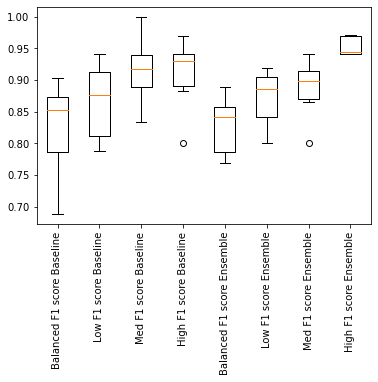

In [133]:
fig, ax = plt.subplots()
labels = ['Balanced F1 score Baseline','Low F1 score Baseline', 'Med F1 score Baseline','High F1 score Baseline','Balanced F1 score Ensemble','Low F1 score Ensemble','Med F1 score Ensemble','High F1 score Ensemble' ]
ax.boxplot([balanced_f1_scores_baseline,low_f1_scores_baseline, med_f1_scores_baseline,high_f1_scores_baseline,balanced_f1_scores_ensemble,low_f1_scores_ensemble,med_f1_scores_ensemble,high_f1_scores_ensemble])
ax.set_xticklabels(labels, rotation=90)
plt.show()

Boxplot for Accuracy and F1 scores

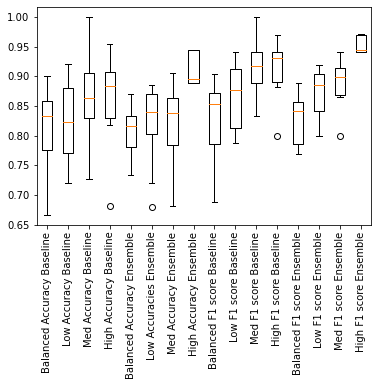

In [139]:
fig, ax = plt.subplots()
labels = ['Balanced Accuracy Baseline','Low Accuracy Baseline', 'Med Accuracy Baseline','High Accuracy Baseline','Balanced Accuracy Ensemble','Low Accuracies Ensemble','Med Accuracy Ensemble','High Accuracy Ensemble','Balanced F1 score Baseline','Low F1 score Baseline', 'Med F1 score Baseline','High F1 score Baseline','Balanced F1 score Ensemble','Low F1 score Ensemble','Med F1 score Ensemble','High F1 score Ensemble' ]
ax.boxplot([balanced_accuracies_baseline,low_accuracies_baseline, med_accuracies_baseline,high_accuracies_baseline,balanced_accuracies_ensemble,low_accuracies_ensemble,med_accuracies_ensemble,high_accuracies_ensemble,balanced_f1_scores_baseline,low_f1_scores_baseline, med_f1_scores_baseline,high_f1_scores_baseline,balanced_f1_scores_ensemble,low_f1_scores_ensemble,med_f1_scores_ensemble,high_f1_scores_ensemble])
ax.set_xticklabels(labels, rotation=90)
plt.show()